# Import

In [85]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import optuna

import random
SEED = 20033002
random.seed(SEED)
np.random.seed(SEED)

# Data preprocessing

In [86]:
AUX_DATA_ROOT = "./data"

train = pd.read_csv(path.join(AUX_DATA_ROOT, 'train.csv'), index_col='id')
test = pd.read_csv(path.join(AUX_DATA_ROOT, 'public_test.csv'), index_col='id')

target = 'Цена'
train_idx = train.shape[0]
Y = train[target]

train.head()

,Тип_жилья,Широта,Долгота,Город,Индекс,Площадь,Этаж,Размер_участка,Расход_тепла,Ктгр_энергоэффективности,...,Нлч_парковки,Нлч_почтового_ящика,Нлч_балкона,Нлч_террасы,Нлч_подвала,Нлч_гаража,Нлч_кондиционера,Последний_этаж,Верхний_этаж,Цена
id,,,,,,,,,,,,,,,,,,,,,
35831305,квартира,48.875375,2.483820,rosny-sous-bois,4575,64.0,2.0,NaN,150.0,C,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,295000.0
35854039,квартира,45.522327,4.869322,vienne,1793,75.0,NaN,NaN,220.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194000.0
36058437,квартира,43.672828,1.281469,mondonville,1425,42.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,179000.0
35989147,дом,44.158752,1.532081,caussade,4077,102.0,NaN,2000.0,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,205000.0
36029269,квартира,47.655212,-2.754196,vannes,2498,84.0,3.0,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,508000.0


## Filling NaN

In [87]:
train.isna().sum()

Тип_жилья                       0
Широта                          0
Долгота                         0
Город                           0
Индекс                          0
Площадь                       351
Этаж                        19356
Размер_участка              15229
Расход_тепла                12844
Ктгр_энергоэффективности    12844
Кво_вредных_выбросов        13215
Ктгр_вредных_выбросов       13215
Направление                 19813
Кво_комнат                   1106
Кво_спален                   1908
Кво_ванных                      0
Кво_фото                     9350
Нлч_парковки                    0
Нлч_почтового_ящика             0
Нлч_балкона                     0
Нлч_террасы                     0
Нлч_подвала                     0
Нлч_гаража                      0
Нлч_кондиционера                0
Последний_этаж                  0
Верхний_этаж                    0
Цена                            0
dtype: int64

In [88]:
test.isna().sum()

Тип_жилья                      0
Широта                         0
Долгота                        0
Город                          0
Индекс                         0
Площадь                       82
Этаж                        4129
Размер_участка              3272
Расход_тепла                2731
Ктгр_энергоэффективности    2731
Кво_вредных_выбросов        2823
Ктгр_вредных_выбросов       2823
Направление                 4265
Кво_комнат                   236
Кво_спален                   409
Кво_ванных                     0
Кво_фото                    1926
Нлч_парковки                   0
Нлч_почтового_ящика            0
Нлч_балкона                    0
Нлч_террасы                    0
Нлч_подвала                    0
Нлч_гаража                     0
Нлч_кондиционера               0
Последний_этаж                 0
Верхний_этаж                   0
dtype: int64

In [90]:
train.groupby(by='Тип_жилья')['Направление'].agg(lambda x: x.mode())

Тип_жилья
вилла                           Ю
дом                             Ю
дом на воде              [Ю, Ю-В]
дуплекс                         Ю
земля                           Ю
земля под застройку             Ю
квартира                        Ю
комната                        []
лофт                     [В-З, Ю]
мастерская             [Ю-В, Ю-С]
мельница                      В-З
ночлежка                      Ю-З
особняк                  [Ю, Ю-С]
отель-усадьба                  []
паркинг                  [З, С-В]
пожизненная рента               Ю
разное                          Ю
усадьба                         Ю
участок с землей                Ю
ферма                           Ю
шале                          Ю-В
Name: Направление, dtype: object

In [55]:
def fill_na(df):
    # custom filling
    df = df.copy()
    means = train.groupby(by='Тип_жилья')['Размер_участка'].mean().isna()
    zero_types = means.index[means.values]
    df.loc[df['Тип_жилья'].isin(zero_types), 'Размер_участка'] = 0
    
    means = train.groupby(by='Тип_жилья')['Расход_тепла'].mean().isna()
    zero_types = means.index[means.values]
    df.loc[df['Тип_жилья'].isin(zero_types), ['Расход_тепла', 'Кво_вредных_выбросов']] = 0

    mode = train.groupby(by='Тип_жилья')['Ктгр_энергоэффективности'].agg(lambda x: x.mode())
    empty_indices = [i for i, x in enumerate(mode.values) if isinstance(x, np.ndarray) and len(x) == 0]
    unk_types = mode.index[empty_indices]
    df.loc[df['Тип_жилья'].isin(unk_types), ['Ктгр_энергоэффективности', 'Ктгр_вредных_выбросов']] = 'unkown'
    
    mode = train.groupby(by='Тип_жилья')['Направление'].agg(lambda x: x.mode())
    empty_indices = [i for i, x in enumerate(mode.values) if isinstance(x, np.ndarray) and len(x) == 0]
    unk_types = mode.index[empty_indices]
    df.loc[df['Тип_жилья'].isin(unk_types), 'Направление'] = 'unkown'
    
    df.fillna({'Кво_фото': 0}, inplace=True)
    df.loc[(df['Тип_жилья'] == 'комната') & df['Кво_спален'].isna(), 'Кво_спален'] = 1
    
    nan_num_cols = ['Площадь', 'Кво_комнат', 'Кво_спален', 'Размер_участка','Расход_тепла', 'Кво_вредных_выбросов']
    med_groups = train.groupby('Тип_жилья')[nan_num_cols].median()

    for col in nan_num_cols:
        df[col] = df.apply(
            lambda row: med_groups[col][row['Тип_жилья']] if pd.isna(row[col]) else row[col],
            axis=1)
    
    # simple filling
    si_n = SimpleImputer(strategy='median')
    si_c = SimpleImputer(strategy='most_frequent')
    
    num_cols = df.select_dtypes(include='number').columns
    si_n.fit(train[num_cols])
    df[num_cols] = si_n.transform(df[num_cols])
    
    cat_cols = df.select_dtypes(include='O').columns
    si_c.fit(train[cat_cols])
    df[cat_cols] = si_c.transform(df[cat_cols])
    
    return df

test = fill_na(test)
train = fill_na(train)

df = pd.concat((train.drop(columns=target), test))
df.isna().sum().sum()

0

## Exploratory Data Analysis (EDA)

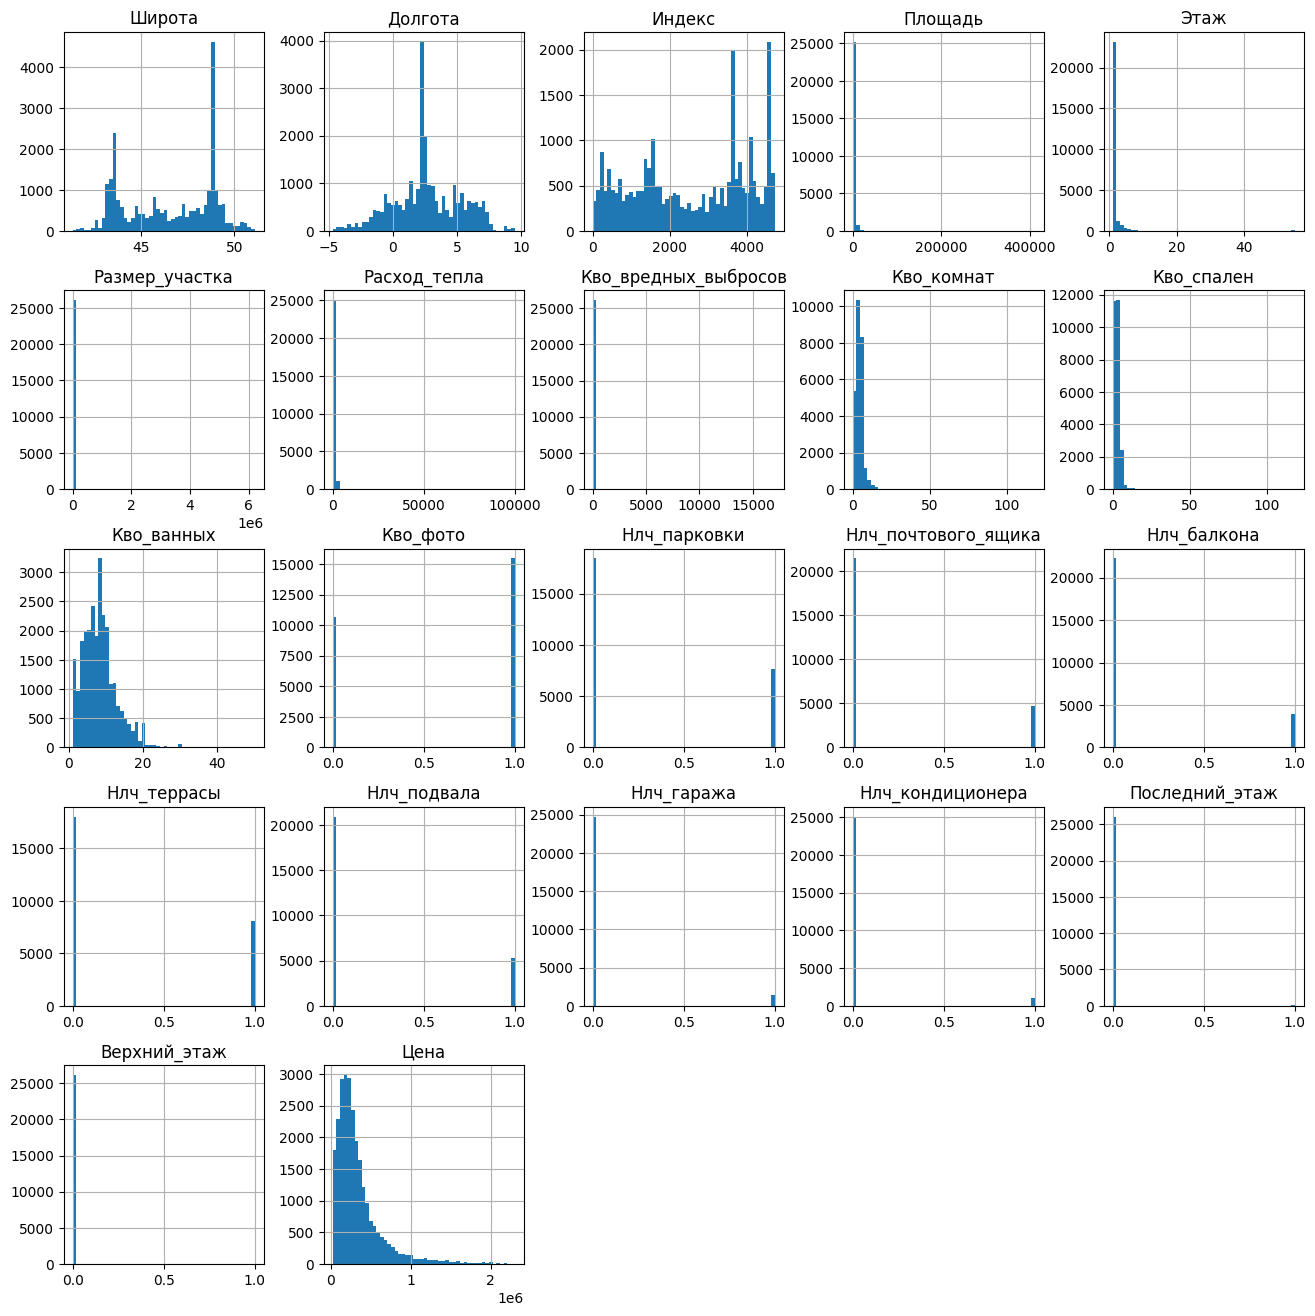

In [56]:
train.select_dtypes(include='number').hist(bins=50, figsize=(16, 16))
plt.show()

### Clustering example

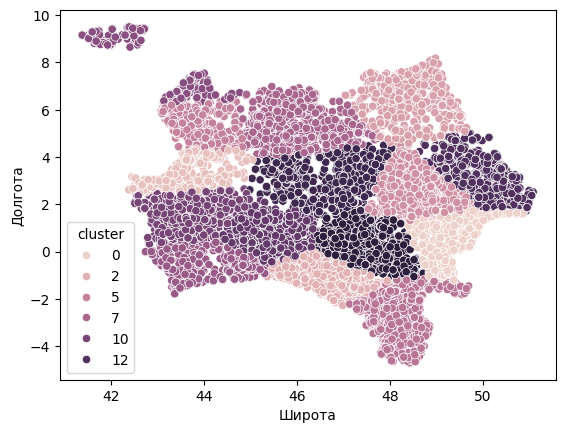

,Широта,Долгота,cluster,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9,Centroid_10,Centroid_11,Centroid_12,Centroid_13,Centroid_14
id,,,,,,,,,,,,,,,,,,
35831305,48.875375,2.483820,4,1.861910,5.524649,4.343922,4.153946,0.125192,5.968955,5.326387,4.204772,5.591455,7.224722,5.289429,3.998422,1.311812,2.362927,2.633328
35854039,45.522327,4.869322,7,5.692548,2.506980,6.096292,3.401998,4.103011,1.940456,8.075758,0.728199,5.616398,3.144573,3.782871,4.200185,4.804905,2.194875,4.979323
36058437,43.672828,1.281469,10,5.750237,2.204094,3.723639,7.155064,5.237841,4.078129,6.008742,4.761215,1.945976,5.886928,0.292558,1.745806,6.603585,3.322162,3.901142


In [57]:
X_clust = train[['Широта', 'Долгота']].copy()
kmeans = KMeans(n_clusters=15, n_init=10, random_state=SEED)
X_clust['cluster'] = kmeans.fit_predict(X_clust[['Широта', 'Долгота']])

X_cd = kmeans.transform(X_clust[['Широта', 'Долгота']])
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])], index=X_clust.index)
X_clust = X_clust.join(X_cd)

sns.scatterplot(data=X_clust, x='Широта', y='Долгота', hue='cluster')
plt.show()
X_clust.head(3)

### Example of logarithmic features

In [58]:
cols_to_log = ['Площадь', 'Размер_участка', 'Расход_тепла', 'Кво_вредных_выбросов']
train[cols_to_log].describe()

,Площадь,Размер_участка,Расход_тепла,Кво_вредных_выбросов
count,26157.000000,2.615700e+04,26157.000000,26157.000000
mean,1075.334518,1.963756e+03,317.045571,24.550904
std,5523.586779,4.094471e+04,897.527834,243.870292
min,1.000000,0.000000e+00,0.000000,0.000000
25%,74.000000,9.450000e+01,168.000000,10.000000
50%,116.000000,3.030000e+02,182.000000,14.000000
75%,234.000000,7.860000e+02,205.000000,23.000000
max,411311.000000,6.203700e+06,100000.000000,17024.000000


In [59]:
def log_nan(row):
    row[row < 1] = 1
    return np.log(row)

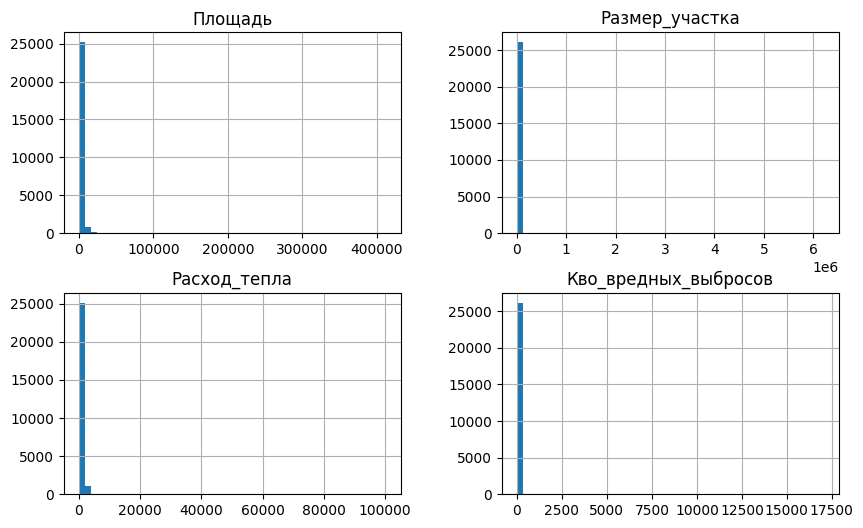

In [60]:
train[cols_to_log].hist(bins=50, figsize=(10, 6))
plt.show()

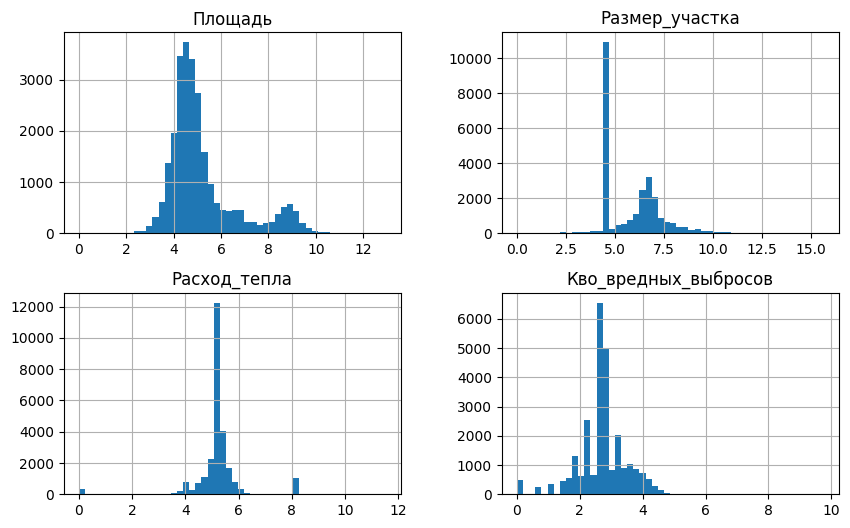

In [61]:
train[cols_to_log].apply(log_nan).hist(bins=50, figsize=(10, 6))
plt.show()

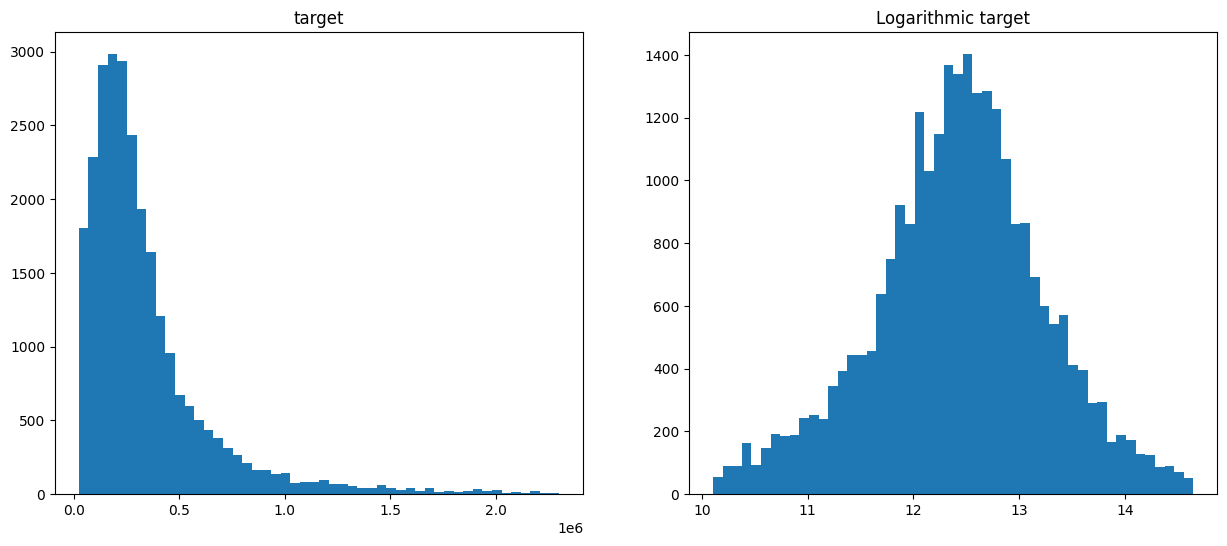

In [62]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(train[target], bins=50)
plt.title('target')

plt.subplot(1, 2, 2)
plt.hist(np.log(train[target]), bins=50)
plt.title('Logarithmic target')
plt.show()

### Logarithmic and count features

In [63]:
df_ext = df.copy()

cols_to_log = ['Площадь', 'Размер_участка', 'Расход_тепла', 'Кво_вредных_выбросов']
log_cols = ['Лог_' + col for col in cols_to_log]
df_ext[log_cols] = df[cols_to_log].apply(log_nan)

In [64]:
bool_cols = ['Нлч_парковки', 'Нлч_почтового_ящика', 'Нлч_балкона', 'Нлч_террасы', 'Нлч_подвала', 
            'Нлч_гаража', 'Нлч_кондиционера']
df_ext['Плюшки'] = df_ext[bool_cols].sum(axis=1)
df_ext.head()

,Тип_жилья,Широта,Долгота,Город,Индекс,Площадь,Этаж,Размер_участка,Расход_тепла,Ктгр_энергоэффективности,...,Нлч_подвала,Нлч_гаража,Нлч_кондиционера,Последний_этаж,Верхний_этаж,Лог_Площадь,Лог_Размер_участка,Лог_Расход_тепла,Лог_Кво_вредных_выбросов,Плюшки
id,,,,,,,,,,,,,,,,,,,,,
35831305,квартира,48.875375,2.483820,rosny-sous-bois,4575.0,64.0,2.0,94.5,150.0,C,...,1.0,0.0,0.0,0.0,0.0,4.158883,4.548600,5.010635,2.484907,2.0
35854039,квартира,45.522327,4.869322,vienne,1793.0,75.0,2.0,94.5,220.0,D,...,0.0,0.0,0.0,0.0,0.0,4.317488,4.548600,5.393628,3.931826,0.0
36058437,квартира,43.672828,1.281469,mondonville,1425.0,42.0,2.0,94.5,173.0,D,...,0.0,0.0,0.0,0.0,0.0,3.737670,4.548600,5.153292,2.639057,1.0
35989147,дом,44.158752,1.532081,caussade,4077.0,102.0,2.0,2000.0,188.0,D,...,0.0,0.0,0.0,0.0,0.0,4.624973,7.600902,5.236442,2.890372,1.0
36029269,квартира,47.655212,-2.754196,vannes,2498.0,84.0,3.0,94.5,173.0,D,...,1.0,0.0,0.0,0.0,0.0,4.430817,4.548600,5.153292,2.639057,3.0


### Cluster features 

In [65]:
kmeans = KMeans(n_clusters=15, n_init=10, random_state=SEED)
kmeans.fit(train[['Широта', 'Долгота']])
df_ext['Кластер'] = kmeans.predict(df_ext[['Широта', 'Долгота']])
df_ext['Кластер'] = df_ext['Кластер'].astype("object")

df_cd = kmeans.transform(df_ext[['Широта', 'Долгота']])

df_cd = pd.DataFrame(df_cd, columns=[f"Центр_{i}" for i in range(df_cd.shape[1])], index=df_ext.index)
df_ext = df_ext.join(df_cd)
df_ext.head()

,Тип_жилья,Широта,Долгота,Город,Индекс,Площадь,Этаж,Размер_участка,Расход_тепла,Ктгр_энергоэффективности,...,Центр_5,Центр_6,Центр_7,Центр_8,Центр_9,Центр_10,Центр_11,Центр_12,Центр_13,Центр_14
id,,,,,,,,,,,,,,,,,,,,,
35831305,квартира,48.875375,2.483820,rosny-sous-bois,4575.0,64.0,2.0,94.5,150.0,C,...,5.968955,5.326387,4.204772,5.591455,7.224722,5.289429,3.998422,1.311812,2.362927,2.633328
35854039,квартира,45.522327,4.869322,vienne,1793.0,75.0,2.0,94.5,220.0,D,...,1.940456,8.075758,0.728199,5.616398,3.144573,3.782871,4.200185,4.804905,2.194875,4.979323
36058437,квартира,43.672828,1.281469,mondonville,1425.0,42.0,2.0,94.5,173.0,D,...,4.078129,6.008742,4.761215,1.945976,5.886928,0.292558,1.745806,6.603585,3.322162,3.901142
35989147,дом,44.158752,1.532081,caussade,4077.0,102.0,2.0,2000.0,188.0,D,...,3.861773,5.843233,4.321843,2.122949,5.683645,0.495724,1.435327,6.067547,2.776054,3.515600
36029269,квартира,47.655212,-2.754196,vannes,2498.0,84.0,3.0,94.5,173.0,D,...,9.050716,0.442123,8.412050,4.072727,10.801720,5.886933,4.154200,6.352098,5.792370,3.036566


### Mutual Information (MI) of numeric features

In [66]:
num_cols = df_ext.select_dtypes(include='number').columns

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=SEED)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

make_mi_scores(df_ext[:train_idx][num_cols], train[target])

Индекс                      0.314351
Центр_12                    0.231144
Центр_4                     0.227890
Центр_9                     0.225055
Центр_6                     0.220394
Широта                      0.219292
Центр_0                     0.219277
Центр_10                    0.207308
Центр_5                     0.207044
Центр_2                     0.206563
Центр_14                    0.203858
Центр_3                     0.200802
Центр_11                    0.200556
Долгота                     0.199827
Площадь                     0.194071
Лог_Площадь                 0.193220
Центр_7                     0.193029
Центр_13                    0.191277
Центр_8                     0.189624
Центр_1                     0.189525
Расход_тепла                0.167272
Лог_Расход_тепла            0.163899
Кво_комнат                  0.162807
Кво_спален                  0.146297
Кво_вредных_выбросов        0.128659
Лог_Кво_вредных_выбросов    0.118394
Лог_Размер_участка          0.106730
Р

### Principal Component Analysis (PCA)

#### PCA for inital numeric features

In [67]:
pca_cols = ['Площадь', 'Размер_участка', 'Расход_тепла', 'Кво_вредных_выбросов',
            'Лог_Площадь', 'Лог_Размер_участка', 'Лог_Расход_тепла', 'Лог_Кво_вредных_выбросов', 
            'Кво_комнат', 'Кво_спален', 'Кво_ванных']

train_pca = df_ext.iloc[:train_idx][pca_cols].copy()
train_pca_scaled = (train_pca - train_pca.mean(axis=0)) / train_pca.std(axis=0)
pca = PCA(random_state=SEED)

X_pca = pca.fit_transform(train_pca_scaled)

component_names = [f"PC{i}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.384712,-0.928960,-0.271859,-0.171710,0.117510,-0.202452,1.131266,-0.665680,-0.316842,0.009385,-0.060657
1,-0.680058,-0.221485,-1.274023,-0.839499,0.366502,-0.863232,-0.161555,0.194052,-0.031016,-0.401844,-0.014181
2,-1.586393,-1.008358,-0.447292,0.018417,0.197424,-0.173434,-0.581409,0.092757,-0.427085,0.095352,0.134430
3,0.783854,0.117449,-0.260033,0.564824,-0.033964,0.085845,0.452267,0.860622,-0.143532,0.020655,0.038335
4,-0.561731,-0.690208,-0.276153,-0.168116,-0.016616,-0.105099,-0.855868,-0.379463,-0.226878,0.106244,0.006705


In [68]:
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=component_names,  
    index=train_pca.columns,  
)
loadings

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Площадь,-0.042888,0.353358,0.502278,-0.378117,0.150142,-0.107490,0.009575,0.087372,-0.660117,-0.017330,0.012871
Размер_участка,0.075827,0.096244,0.112971,0.457122,0.757990,-0.355306,-0.092035,-0.221474,0.070329,-0.001642,-0.001807
Расход_тепла,-0.233151,0.494665,-0.163661,0.317309,-0.172724,0.248782,0.010803,-0.326173,-0.132985,-0.597446,0.024883
Кво_вредных_выбросов,-0.004421,0.183729,-0.334160,-0.277607,0.503656,0.675504,0.024545,-0.038248,-0.003425,0.255808,0.002357
Лог_Площадь,-0.000784,0.437286,0.477988,-0.249777,-0.045844,0.043831,-0.013827,-0.077238,0.712354,0.013177,-0.010832
Лог_Размер_участка,0.323826,0.273056,0.099091,0.459252,-0.028465,0.217194,0.120610,0.729922,-0.007743,0.017871,-0.064423
Лог_Расход_тепла,-0.144550,0.513554,-0.326747,0.126309,-0.245718,-0.317953,0.014023,-0.096110,-0.070072,0.645558,0.009377
Лог_Кво_вредных_выбросов,0.118068,0.220562,-0.498060,-0.417417,0.165915,-0.426775,-0.077262,0.350668,0.133034,-0.397824,-0.023389
Кво_комнат,0.598959,0.068913,-0.027345,-0.022969,-0.108802,0.035423,-0.217892,-0.188213,-0.054147,0.006180,0.732298
Кво_спален,0.571897,0.065037,-0.027884,-0.039664,-0.128902,0.046676,-0.331722,-0.274091,-0.092247,0.010061,-0.673634


In [69]:
pca_mi = make_mi_scores(X_pca, train[target])
pca_mi

PC0     0.191245
PC1     0.169319
PC4     0.156414
PC8     0.144177
PC9     0.138456
PC5     0.135458
PC3     0.135070
PC2     0.126248
PC6     0.122356
PC10    0.103659
PC7     0.099129
Name: MI Scores, dtype: float64

In [70]:
top_pca = list(pca_mi.index[:5])
df_pca = df_ext[pca_cols].copy()
df_pca_scaled = (df_pca - df_pca.iloc[:train_idx].mean(axis=0)) / df_pca.iloc[:train_idx].std(axis=0)
df_pca = pca.transform(df_pca_scaled)

df_ext[top_pca] = df_pca[:, [int(pca_t[2:]) for pca_t in top_pca]]

#### PCA for cluster features

In [71]:
pca_cols = ['Центр_0', 'Центр_1','Центр_2', 'Центр_3', 
            'Центр_4', 'Центр_5', 'Центр_6', 'Центр_7',
            'Центр_8', 'Центр_9', 'Центр_10', 'Центр_11', 
            'Центр_12', 'Центр_13', 'Центр_14',]

train_pca = df_ext.iloc[:train_idx][pca_cols].copy()
pca = PCA(random_state=SEED)

X_pca = pca.fit_transform(train_pca)

# Convert to dataframe
component_names = [f"PC_ц{i}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

pca_mi = make_mi_scores(X_pca, train[target])
pca_mi

PC_ц0     0.234372
PC_ц5     0.213921
PC_ц1     0.199394
PC_ц4     0.187374
PC_ц9     0.169992
PC_ц3     0.169297
PC_ц2     0.169057
PC_ц11    0.167679
PC_ц10    0.167003
PC_ц14    0.166981
PC_ц6     0.154049
PC_ц13    0.153805
PC_ц7     0.149320
PC_ц12    0.148683
PC_ц8     0.135141
Name: MI Scores, dtype: float64

In [72]:
top_pca_c = list(pca_mi.index[:10])
df_pca = pca.transform(df_ext[pca_cols])

df_ext[top_pca_c] = df_pca[:, [int(pca_t[4:]) for pca_t in top_pca_c]]

### Correlation and MI of all numeric features in train

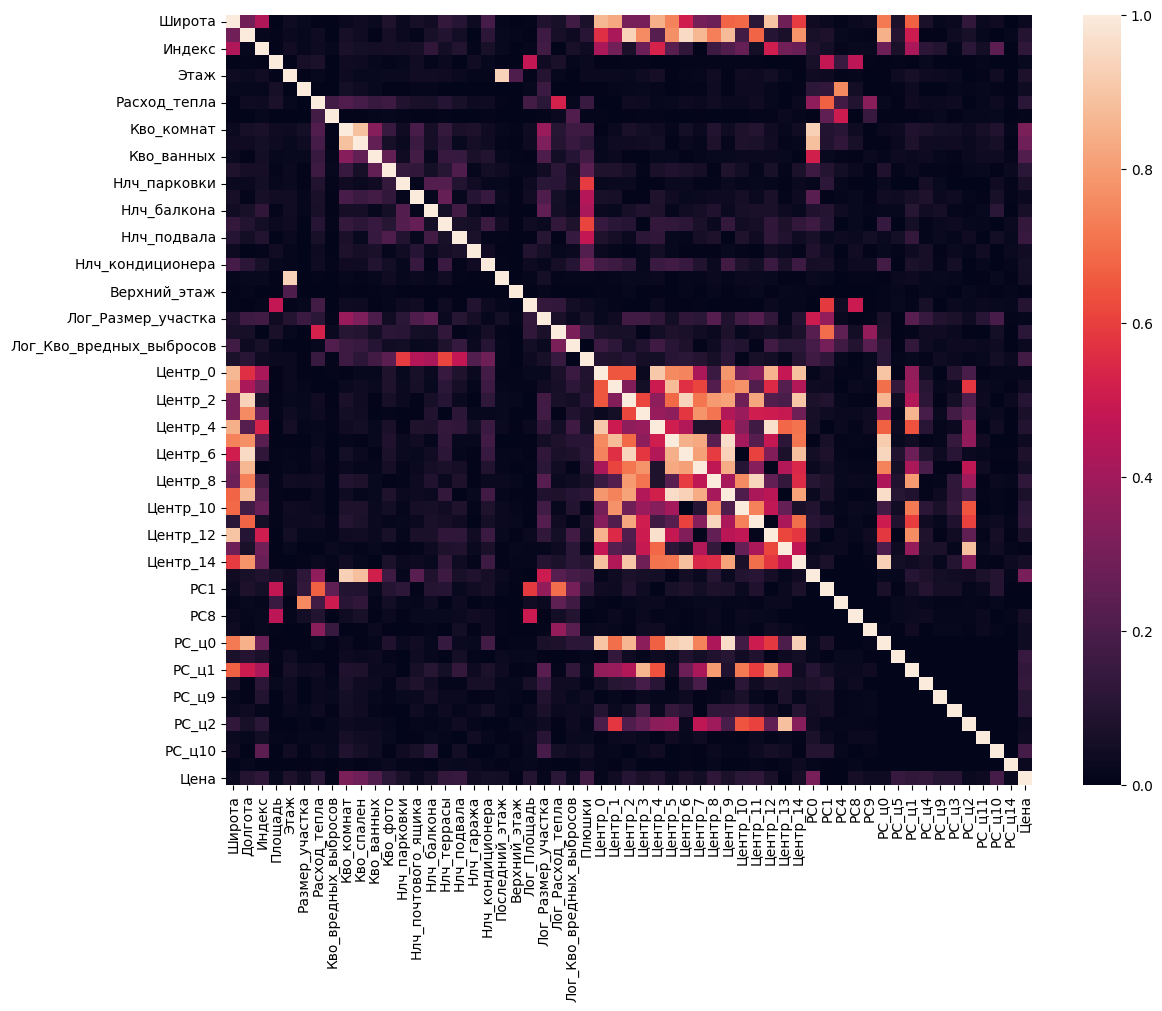

In [73]:
train = pd.concat((df_ext[:train_idx], Y), axis=1)
corr = train.corr(numeric_only=True).abs()
plt.figure(figsize=(13, 10))
sns.heatmap(corr, annot=False)
plt.show()

In [74]:
num_cols = df_ext.select_dtypes(include='number').columns

make_mi_scores(df_ext[:train_idx][num_cols], train[target])

Индекс                      0.315030
PC_ц0                       0.235041
Центр_12                    0.230926
Центр_4                     0.228357
Центр_9                     0.224656
Широта                      0.220024
Центр_6                     0.219701
Центр_0                     0.219000
PC_ц5                       0.214253
Центр_10                    0.207713
Центр_5                     0.206611
Центр_2                     0.206397
Центр_14                    0.203562
PC_ц1                       0.200577
Центр_11                    0.199943
Центр_3                     0.199689
Долгота                     0.199285
Площадь                     0.193017
Центр_7                     0.192796
Лог_Площадь                 0.191863
PC0                         0.191332
Центр_13                    0.190319
Центр_8                     0.189773
Центр_1                     0.188892
PC_ц4                       0.187527
PC_ц9                       0.170688
PC_ц3                       0.169744
Р

## Outliers processing

In [75]:
outls_clf = IsolationForest(contamination=0.01, random_state=SEED, max_features=0.5, n_estimators=500)
cat_cols = df_ext.select_dtypes(include='O').columns

anomal_ind = outls_clf.fit_predict(df_ext.drop(columns=cat_cols)[:train_idx])
anomal_ind = anomal_ind == 1

train_clean = df_ext.iloc[:train_idx].loc[anomal_ind]
df_ext = pd.concat((train_clean, df_ext[train_idx:]))

train_idx_old = train_idx
train_idx = train_clean.shape[0]
print(f'Total outliers in the data: {train_idx_old - train_idx}')

Total outliers in the data: 262


## Deleting bad features

In [76]:
# these columns had low feature importance value in CatBoost 
# (view Model and training -> Training -> Catboost)
drop_cols = [
    'Последний_этаж', 'Верхний_этаж', 'Этаж',
    'Центр_2', 'Центр_3', 'Центр_4', 'Центр_6', 'Центр_7'
    ]
df_ext.drop(columns=drop_cols, inplace=True)

# Model and training

In [77]:
# MAPE for catboost log preds
class MyMAPE: 
    @staticmethod
    def mape(y_t, y_p):
        return mape(y_t, y_p)
    
    def get_final_error(self, error, weight):
        return error
    
    def is_max_optimal(self):
        # the larger metric value the better
        return False

    def evaluate(self, y_p, y_t, weight):
        score = self.mape(np.exp(y_t), np.exp(y_p[0]))
        return score, 0

## Selection of training parameters

In [78]:
def trial_to_params(trial):
    params = {
        'random_seed': SEED,
        'eval_metric': MyMAPE(),
        'iterations': 1000, 
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10, step=1e-5),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, step=1e-7),
        'loss_function': 'RMSE',
        'leaf_estimation_method': "Newton",
        'bootstrap_type': 'MVS',
        'boosting_type': 'Plain',
        'grow_policy': 'Depthwise',
        'rsm': trial.suggest_float('rsm', 0.2, 1, step=1 / (df_ext.columns.size + 1e-5)),
        'depth': trial.suggest_int('depth', 9, 13),
        'verbose': 0,
    }
    return params

def objective(trial, train_pool, val_pool):
    params = trial_to_params(trial)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=150, use_best_model=True)

    return model.best_score_['validation']['MyMAPE']


In [79]:
y = np.log(Y)[anomal_ind] # target = log(target)
X = df_ext[:train_idx]

cat_cols = list(df_ext.select_dtypes(include='O').columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
val_pool = Pool(X_val, y_val, cat_features=cat_cols)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(), direction='minimize')

# time of selection
time_sec = 3600 * 0 + 60 * 5  # 0 hour, 5 min
# study.optimize(
#     lambda x: objective(x, train_pool, val_pool), n_trials=1000, 
#     timeout=time_sec, show_progress_bar=True, n_jobs=-1)

In [28]:
# print(f'Best MAPE value = {study.best_value:.6f}')
# print('Params of best trial:')
# trial_to_params(study.best_trial)

Best MAPE value = 0.273765
Params of best trial:


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/optuna/distributions.py:689: UserWarning: The distribution is specified by [0.2, 1] and step=0.018518521947874435, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9962964437586007].
  warnings.warn(


{'random_seed': 20033002,
 'eval_metric': <metric.MyMAPE at 0x741ed0983740>,
 'iterations': 1000,
 'l2_leaf_reg': 2.6769600000000002,
 'learning_rate': 0.06485859999999999,
 'loss_function': 'RMSE',
 'leaf_estimation_method': 'Newton',
 'bootstrap_type': 'MVS',
 'boosting_type': 'Plain',
 'grow_policy': 'Depthwise',
 'rsm': 0.23703704389574887,
 'depth': 9,
 'verbose': 0}

## Training


In [82]:
best_params = {
    'random_seed': SEED,
    'iterations': 10000,
    'eval_metric': MyMAPE(),
    'l2_leaf_reg': 2.81255,
    'learning_rate': 0.0721322,
    'loss_function': 'RMSE',
    'leaf_estimation_method': 'Newton',
    'bootstrap_type': 'MVS',
    'boosting_type': 'Plain',
    'grow_policy': 'Depthwise',
    'rsm': 0.4535,
    'depth': 10,
    'verbose': 1000,
    }

### CatBoost model

In [83]:
model = CatBoostRegressor(**best_params)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=300,use_best_model=True)

/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


0:	learn: 0.7700213	test: 0.7720458	best: 0.7720458 (0)	total: 63.1ms	remaining: 10m 30s
1000:	learn: 0.0760418	test: 0.2707874	best: 0.2707708 (999)	total: 38.3s	remaining: 5m 44s
2000:	learn: 0.0353719	test: 0.2689619	best: 0.2689619 (2000)	total: 1m 9s	remaining: 4m 37s
3000:	learn: 0.0203846	test: 0.2683281	best: 0.2683152 (2845)	total: 1m 39s	remaining: 3m 52s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2682036056
bestIteration = 3693

Shrink model to first 3694 iterations.


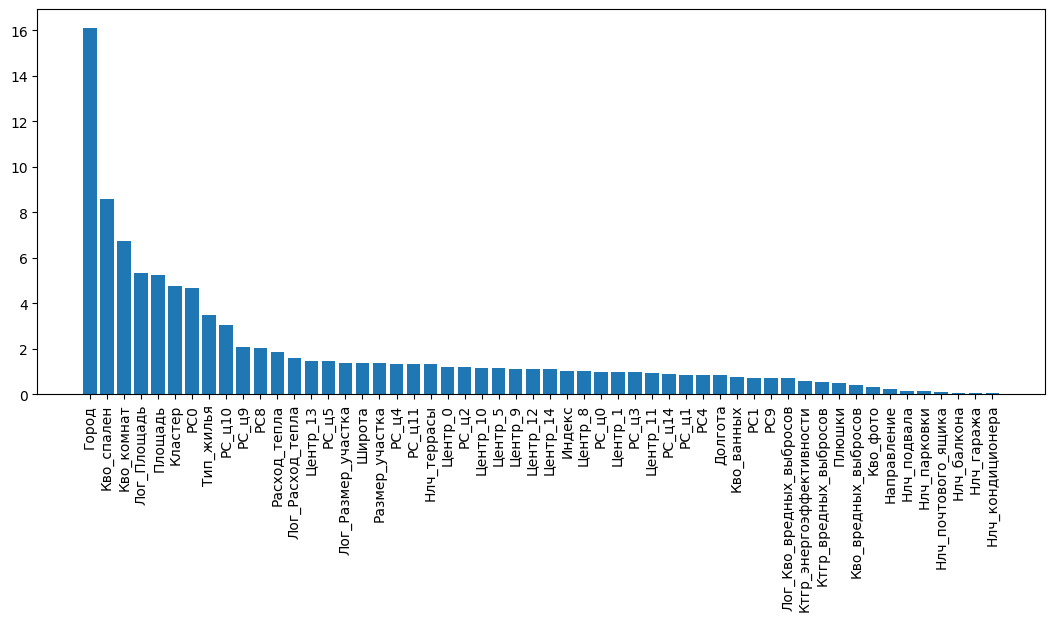

Index(['Нлч_парковки', 'Нлч_почтового_ящика', 'Нлч_балкона', 'Нлч_гаража',
       'Нлч_кондиционера'],
      dtype='object')

In [31]:
feature_importances = model.get_feature_importance()

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = df_ext.columns[sorted_indices]
plt.figure(figsize=(13, 5))
plt.bar(range(len(sorted_feature_names)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.show()
sorted_feature_names[-5:]

### Bagging with KFold

In [32]:
kf = KFold(n_splits=6, shuffle=True, random_state=SEED)

y = np.log(Y)[anomal_ind]
X = df_ext[:train_idx]

cat_cols = list(df_ext.select_dtypes(include='O').columns)

models = []
weights = []

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_pool = Pool(data=x_train, label=y_train, cat_features=cat_cols)
    val_pool = Pool(data=x_test, label=y_test, cat_features=cat_cols)

    model = CatBoostRegressor(**best_params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=300, use_best_model=True)
    models.append(model)

    weights.append(model.best_score_['validation']['MyMAPE'])
    l = 20
    print('^' * 3 + '-' * l + str(i + 1) + '-' * l + '^' * 3)
    

models = np.array(models)

mean_val_score = np.mean(weights)
print(f'Mean validation score = {mean_val_score:.6f}')
print('Validation MAPE score per model:', weights)

weights = [1/w for w in weights]
weights = np.array(weights) / np.sum(weights)
print('Weights of the models in the ensemble:', weights)

/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


0:	learn: 0.7634247	test: 0.8074076	best: 0.8074076 (0)	total: 42.8ms	remaining: 7m 7s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2742771811
bestIteration = 4584

Shrink model to first 4585 iterations.
^^^--------------------1--------------------^^^
0:	learn: 0.7705311	test: 0.7387755	best: 0.7387755 (0)	total: 46.1ms	remaining: 7m 40s


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2484217692
bestIteration = 4487

Shrink model to first 4488 iterations.
^^^--------------------2--------------------^^^
0:	learn: 0.7690917	test: 0.7573627	best: 0.7573627 (0)	total: 46.6ms	remaining: 7m 45s


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.260569717
bestIteration = 3401

Shrink model to first 3402 iterations.
^^^--------------------3--------------------^^^
0:	learn: 0.7675035	test: 0.7731916	best: 0.7731916 (0)	total: 41.2ms	remaining: 6m 51s


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2635815199
bestIteration = 3884

Shrink model to first 3885 iterations.
^^^--------------------4--------------------^^^
0:	learn: 0.7700013	test: 0.7573055	best: 0.7573055 (0)	total: 43.2ms	remaining: 7m 11s


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.256362938
bestIteration = 3785

Shrink model to first 3786 iterations.
^^^--------------------5--------------------^^^
0:	learn: 0.7661150	test: 0.7803138	best: 0.7803138 (0)	total: 45.4ms	remaining: 7m 33s


/media/mikhail_solovev/Memory/py_proj/venvs/rucode_2024/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2630437137
bestIteration = 4631

Shrink model to first 4632 iterations.
^^^--------------------6--------------------^^^
Mean validation score = 0.261043
Validation MAPE score per model: [0.27427718106017895, 0.24842176917307313, 0.26056971702853393, 0.2635815198717366, 0.256362937969488, 0.26304371366656976]
Weights of the models in the ensemble: [0.15848245 0.1749771  0.16681954 0.16491339 0.16955696 0.16525056]


In [33]:
def get_pred(x, strat=''):
    preds = np.zeros(x.shape[0])
    if strat == 'top': 
        preds = np.exp(models[np.argmax(weights)].predict(x))
    else:
        for m, w in zip(models, weights):
            if strat == 'weighted': preds += w * np.exp(m.predict(x))
            else: preds += np.exp(m.predict(x))

    if strat == '': preds /= len(models)
    return preds

# Сreating a submission

In [34]:
X_test = df_ext[train_idx:]
test_pool = Pool(X_test, cat_features=cat_cols)
strat = 'weighted'
y_pred = get_pred(test_pool, strat=strat)

submission = pd.read_csv(path.join(AUX_DATA_ROOT, 'public_sample_submission_seed_0.csv'))
submission[target] = y_pred

sub_pref = 'baging_w_' if strat == 'weighted' else 'sub_bag_'
sub_name = sub_pref + f'{1 - mean_val_score:.4f}_{SEED}.csv'
submission.to_csv(path.join(AUX_DATA_ROOT, sub_name))
sub_name

'baging_w_0.7390_20033002.csv'